In [2]:
import argparse
from datetime import datetime
import json
from pprint import pprint

from explorecourses import *  # pip install the explorecourses package
import pandas as pd

In [3]:
import requests
from typing import List, Tuple
import xml.etree.ElementTree as ET

In [4]:
_URL = "https://explorecourses.stanford.edu/"
_session = requests.Session()

In [5]:
def get_academic_year_str(years_ago: int = 0) -> str:
    """
    Get the academic year in string form for some number of academic years ago.

    Args:
        years_ago (int): Number of academic years prior to now.

    Returns:
        Academic year formatted like '{start_year}-{end_year}'.
    """
    academic_year_start = datetime.now().year - years_ago
    
    # If before September, academic year started last year
    if datetime.now().month < 9:
        academic_year_start -= 1

    return f"{academic_year_start}-{academic_year_start+1}"


def get_course_dict(course: Course, include_sections: bool = True):
    """
    Converts course to string dict representation.

    Args:
        course (Course): Course to convert.

    Returns:
        course_dict: Course represented as dict of strings.
    """
    if include_sections:
        for section in course.sections:
            for schedule in section.schedules:
                schedule.instructors = tuple(str(ins) 
                                             for ins in schedule.instructors)
            section.schedules = tuple(schedule.__dict__ 
                                      for schedule in section.schedules)
            section.attributes = tuple(str(attr)
                                       for attr in section.attributes)
        course.sections = json.dumps(tuple(section.__dict__ 
                                           for section in course.sections))
    else:
        course.sections = None

    course.attributes = tuple(str(attr) for attr in course.attributes)
    course.objectives = tuple(str(obj) for obj in course.objectives)
    course.tags = tuple(str(tag) for tag in course.tags)

    course_dict = course.__dict__
    return course_dict 


def download_one_year_course_data(years_ago: int = 0, 
                                  verbose: bool = False,
                                  include_sections: bool = True) -> pd.DataFrame:
    """
    Downloads a single year of course data and converts to pandas DataFrame.

    Args:
        years_ago (int): Number of academic years ago (including current) to 
                         download.
    verbose (bool): Whether to use verbose output.
        
    Returns:
        one_year_course_df (pd.DataFrame): One year of course data.
    """
    academic_year_str = get_academic_year_str(years_ago)
    if verbose: 
        print(f"Downloading data for academic year: {academic_year_str}")
        
    def get_courses_by_query(query: str, *filters: str, 
                             year=None) -> List[Course]:

        """
        Gets all courses matched by a search query.
        Args:
            query (str): The search query.
            *filters (str): Search query filters.
            year (Optional[str]): The academic year within which to retrieve 
                courses (e.g., "2017-2018"). Defaults to None.
        Returns:
            List[Course]: The courses matching the search query.
        """
        
        url = _URL + "search"

        payload = {
            "view": "xml-20200810",
            "filter-coursestatus-Active": "on",
            "q": query,
        }
        payload.update({f: "on" for f in filters})
        if year:
            payload.update({"academicYear": year.replace('-', '')})

        res = _session.get(url, params=payload)

        root = ET.fromstring(res.content)
        courses = root.findall(".//course")

        return [Course(course) for course in courses]
    
    courses = get_courses_by_query(query='all courses', 
                                   year=academic_year_str)
    if verbose:
        print(f"Converting data for academic year: {academic_year_str}")
    return pd.DataFrame(data=(get_course_dict(course, include_sections) 
                              for course in courses))



def download_multiple_years_course_data(num_years: int = 11, 
                                        verbose: bool = False,
                                        include_sections: bool = True
                                       ) -> pd.DataFrame:
    """
    Downloads multiple years of course data and converts to pandas DataFrame.

    Args:
        num_years (int): The number of years (including current) to download.
        verbose (bool): Whether to use verbose output.
    """
    return pd.concat(
            objs=(download_one_year_course_data(years_ago, 
                                                verbose, 
                                                include_sections)
                  for years_ago in range(num_years)), 
            axis=0)

In [7]:
num_years = 11
verbose = True
include_sections = True

all_years_course_data_df = download_multiple_years_course_data(
        num_years, verbose, include_sections)

Converting data for academic year: 2020-2021
Converting data for academic year: 2019-2020
Converting data for academic year: 2018-2019
Converting data for academic year: 2017-2018
Converting data for academic year: 2016-2017
Converting data for academic year: 2015-2016
Converting data for academic year: 2014-2015
Converting data for academic year: 2013-2014
Converting data for academic year: 2012-2013
Converting data for academic year: 2011-2012
Converting data for academic year: 2010-2011


In [8]:
all_years_course_data_df.to_csv('all_course_data_01_13_2021.csv') 

### Start here if you have already saved it

In [4]:
all_2010s_df = pd.read_csv('all_course_data_01_13_2021.csv')

In [5]:
all_2010s_df[['year', 'code']].drop_duplicates().groupby('year').count()

,code
year,
2010-2011,3162
2011-2012,3282
2012-2013,3279
2013-2014,3525
2014-2015,3914
2015-2016,4083
2016-2017,4334
2017-2018,4459
2018-2019,4576


In [6]:
all_2010s_df = all_2010s_df.loc[(all_2010s_df['year'] != '2020-2021')]

In [7]:
academic_year_df = all_2010s_df[all_2010s_df['attributes'].apply(lambda x: 'NQTR::AUT' in x or 'NQTR::WIN' in x or 'NQTR::SPR' in x)]\
    [['year', 'subject', 'code', 'title', 'attributes', 'description', 'sections', 'gers']]

academic_year_df['sections_clean'] = academic_year_df['sections']\
    .apply(lambda x: [(c['component'], c['curr_class_size'], c['term'].split()[-1]) 
                     for c in json.loads(x) 
                     if c['term'].split()[-1].lower() != 'summer'])
academic_year_df = academic_year_df.explode('sections_clean')

In [8]:
academic_year_df = academic_year_df\
    .drop('sections', 'columns')\
    .loc[academic_year_df['sections_clean'].notnull()]

In [9]:
academic_year_df['component'] = academic_year_df['sections_clean'].apply(lambda x: x[0])
academic_year_df['enrollment'] = academic_year_df['sections_clean'].apply(lambda x: x[1])
academic_year_df['term'] = academic_year_df['sections_clean'].apply(lambda x: x[2])
academic_year_df = academic_year_df.drop(['sections_clean', 'attributes'], 'columns')

In [10]:
# Filter discussions, independent studies, labs, thesis/dissertation, and recitation
academic_year_df = academic_year_df[~academic_year_df['component'].isin(
    ['DIS', 'INS', 'LBS', 'T/D', 'RES'])]

In [11]:
term_enrollment_df = academic_year_df\
    .groupby(['year', 'subject', 'code', 'title', 'description', 'term'])\
    .agg({'enrollment': 'sum'})\
    .sort_values(by='year').reset_index()

In [12]:
term_enrollment_df.loc[term_enrollment_df['code'] == '224N']

,year,subject,code,title,description,term,enrollment
6464,2010-2011,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Winter,52
13801,2011-2012,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Autumn,68
21583,2012-2013,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Autumn,110
29587,2013-2014,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Autumn,99
35325,2014-2015,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Autumn,139
44065,2015-2016,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Autumn,174
52955,2016-2017,CS,224N,Natural Language Processing with Deep Learning...,Methods for processing human language informat...,Winter,669
61735,2017-2018,CS,224N,Natural Language Processing with Deep Learning...,Methods for processing human language informat...,Winter,416
71080,2018-2019,CS,224N,Natural Language Processing with Deep Learning...,Methods for processing human language informat...,Winter,471
71857,2018-2019,ARTHIST,224N,The Popular Culture of Abstract Art,Is abstract art inherently elitist? Or gendere...,Winter,12


In [13]:
year_enrollment_df = term_enrollment_df\
    .groupby(['year', 'subject', 'code', 'title', 'description'])\
    .agg({'enrollment': 'sum'})\
    .sort_values(by='year').reset_index()

In [14]:
year_enrollment_df.loc[year_enrollment_df['code'] == '221']

,year,subject,code,title,description,enrollment
156,2010-2011,MCP,221,"Advanced Cell Biology (BIO 214, BIOC 224)",For Ph.D. students. Current research on cell s...,1
653,2010-2011,MS&E,221,Stochastic Modeling,Focus is on time-dependent random phenomena. T...,53
1224,2010-2011,LAW,221,Intellectual Property: Commercial Law,"This seminar, co-taught by eBay's first In-Hou...",5
1293,2010-2011,INDE,221,Human Health and Disease II,"Structure, function, disease, and therapeutics...",91
1376,2010-2011,JAPANGEN,221,"Translating Japan, Translating the West (JAPAN...",Translation lies at the heart of all intercult...,10
...,...,...,...,...,...,...
65977,2019-2020,FILMSTUD,221,Out of Order,This course explores the rise of nonlinear app...,12
66069,2019-2020,GEOPHYS,221,Rivers: The Arteries of Earth's Continents (ES...,"Rivers are the arteries of Earth's continents,...",2
66261,2019-2020,DLCL,221,Materia,Materia is a focal group on post-anthropocentr...,2
66297,2019-2020,ECON,221,Political Economy II (POLISCI 460B),Continuation of 220. Preparation for advanced ...,2


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [16]:
year_enrollment_df['title'] = year_enrollment_df['title'].str.lower()
year_enrollment_df['description'] = year_enrollment_df['description'].str.lower()

### Enrollment in AI classes

In [17]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

[]

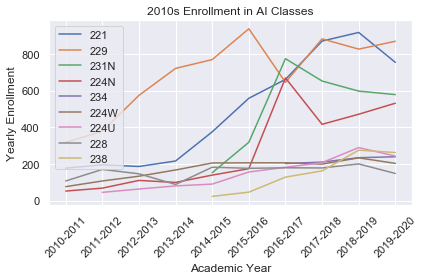

In [18]:
codes = ['221', '229', '231N', '224N', '234', '224W', '224U', '228', '238']

for code in codes:
    code_df = year_enrollment_df.loc[(year_enrollment_df['code'] == code) & (year_enrollment_df['subject'] == 'CS')]
    plt.plot(code_df['year'], code_df['enrollment'], label=code)

plt.ylabel('Yearly Enrollment')
plt.xlabel('Academic Year')
plt.title('2010s Enrollment in AI Classes')
plt.legend()
plt.xticks(rotation=45)
plt.plot()

In [19]:
#year_enrollment_df.to_csv('cs_yearly_enrollment_2010s.csv')

#term_enrollment_df.to_csv('cs_term_enrollment_2010s.csv')

### Enrollment in tech / tech-related classes

In [20]:
import numpy as np

In [21]:
tech_keys = ['data science', 'technology', 'cyber', ' ai ', 'artificial intelligence', 'computer science', 'computer', 'digital']
ethics_keys = ['society', 'ethics', 'moral', 'social impact', 'justice']

In [22]:
year_enrollment_df['tech_description'] = 0
year_enrollment_df['tech_title'] = 0
year_enrollment_df['ethics_description'] = 0
year_enrollment_df['ethics_title'] = 0

for i, row in year_enrollment_df.iterrows():
    year_enrollment_df.at[i, 'tech_title'] = sum([key in row['title'] for key in tech_keys])
    year_enrollment_df.at[i, 'tech_description'] = sum([key in row['description'] for key in tech_keys])
    year_enrollment_df.at[i, 'ethics_title'] = sum([key in row['title'] for key in ethics_keys])
    year_enrollment_df.at[i, 'ethics_description'] = sum([key in row['description'] for key in ethics_keys])

In [23]:
year_enrollment_df = year_enrollment_df.loc[year_enrollment_df.year != '2020-2021']

In [24]:
df_ethics = year_enrollment_df.loc[(year_enrollment_df['ethics_description'] > 0)]
df_ethics = df_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

In [25]:
df_ethics

,enrollment,count
year,,
2010-2011,10412,429
2011-2012,11443,456
2012-2013,9023,499
2013-2014,9745,518
2014-2015,9857,602
2015-2016,10089,617
2016-2017,11579,659
2017-2018,12481,733
2018-2019,11912,724


[]

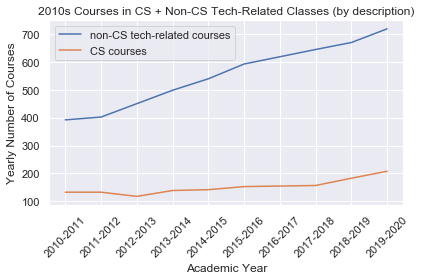

In [26]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['subject'] != 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_cs = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')]
df_cs = df_cs.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.plot(df_tech.index, df_tech['count'], label='non-CS tech-related courses')

plt.plot(df_cs.index, df_cs['count'], label='CS courses')

plt.ylabel('Yearly Number of Courses')
plt.xlabel('Academic Year')
plt.title('2010s Courses in CS + Non-CS Tech-Related Classes (by description)')
plt.legend()
plt.xticks(rotation=45)
plt.plot()

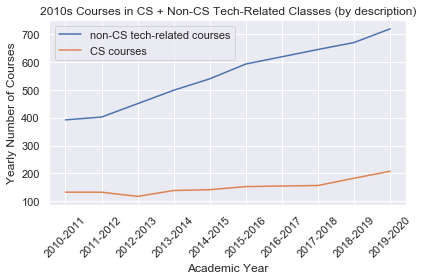

In [27]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['subject'] != 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_cs = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')]
df_cs = df_cs.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(df_tech.index, df_tech['count'], label='non-CS tech-related courses')

ax.plot(df_cs.index, df_cs['count'], label='CS courses')

ax.set_ylabel('Yearly Number of Courses')
ax.set_xlabel('Academic Year')
ax.set_title('2010s Courses in CS + Non-CS Tech-Related Classes (by description)')
ax.legend()
ax.set_xticklabels(df_tech.index, rotation=45)
fig.savefig('cs_non-cs-tech_count.png', format='png')

In [28]:
df_cs

,enrollment,count
year,,
2010-2011,10265,133
2011-2012,12312,133
2012-2013,13955,118
2013-2014,15516,139
2014-2015,17309,142
2015-2016,17580,153
2016-2017,18411,155
2017-2018,19127,157
2018-2019,20179,183


In [29]:
df_tech

,enrollment,count
year,,
2010-2011,13285,392
2011-2012,13260,402
2012-2013,13406,450
2013-2014,12941,498
2014-2015,13337,539
2015-2016,13708,592
2016-2017,14577,618
2017-2018,13850,644
2018-2019,15040,669


[]

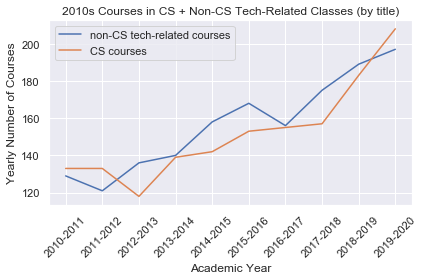

In [30]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_title'] > 0) & (year_enrollment_df['subject'] != 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_cs = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')]
df_cs = df_cs.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.plot(df_tech.index, df_tech['count'], label='non-CS tech-related courses')

plt.plot(df_cs.index, df_cs['count'], label='CS courses')

plt.ylabel('Yearly Number of Courses')
plt.xlabel('Academic Year')
plt.title('2010s Courses in CS + Non-CS Tech-Related Classes (by title)')
plt.legend()
plt.xticks(rotation=45)
plt.plot()

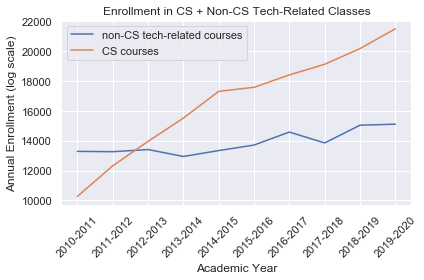

In [31]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['subject'] != 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_cs = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')]
df_cs = df_cs.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(df_tech.index, df_tech['enrollment'], label='non-CS tech-related courses')

ax.plot(df_cs.index, df_cs['enrollment'], label='CS courses')

ax.set_ylabel('Annual Enrollment (log scale)')
ax.set_xlabel('Academic Year')
ax.set_title('Enrollment in CS + Non-CS Tech-Related Classes')
ax.legend()
ax.set_xticklabels(df_tech.index, rotation=45)
fig.savefig('cs_non-cs-tech_enrollment.png', format='png')

In [32]:
df_tech

,enrollment,count
year,,
2010-2011,13285,392
2011-2012,13260,402
2012-2013,13406,450
2013-2014,12941,498
2014-2015,13337,539
2015-2016,13708,592
2016-2017,14577,618
2017-2018,13850,644
2018-2019,15040,669


In [33]:
df_cs

,enrollment,count
year,,
2010-2011,10265,133
2011-2012,12312,133
2012-2013,13955,118
2013-2014,15516,139
2014-2015,17309,142
2015-2016,17580,153
2016-2017,18411,155
2017-2018,19127,157
2018-2019,20179,183


[]

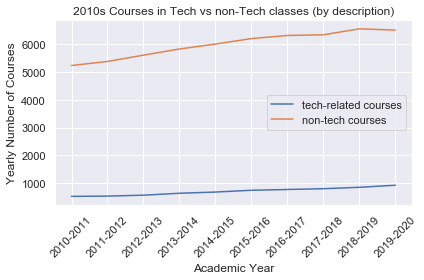

In [34]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_not_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] == 0) & (year_enrollment_df['subject'] != 'CS')]
df_not_tech = df_not_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.plot(df_tech.index, df_tech['count'], label='tech-related courses')

plt.plot(df_not_tech.index, df_not_tech['count'], label='non-tech courses')

plt.ylabel('Yearly Number of Courses')
plt.xlabel('Academic Year')
plt.title('2010s Courses in Tech vs non-Tech classes (by description)')
plt.legend()
plt.xticks(rotation=45)
plt.plot()

In [37]:
df_tech

,enrollment,count
year,,
2010-2011,23550,525
2011-2012,25572,535
2012-2013,27361,568
2013-2014,28457,637
2014-2015,30646,681
2015-2016,31288,745
2016-2017,32988,773
2017-2018,32977,801
2018-2019,35219,852


In [35]:
df_not_tech

,enrollment,count
year,,
2010-2011,110770,5239
2011-2012,111471,5385
2012-2013,110689,5613
2013-2014,112527,5834
2014-2015,113253,6013
2015-2016,111285,6210
2016-2017,113821,6322
2017-2018,112382,6345
2018-2019,114834,6561


<Figure size 432x288 with 0 Axes>

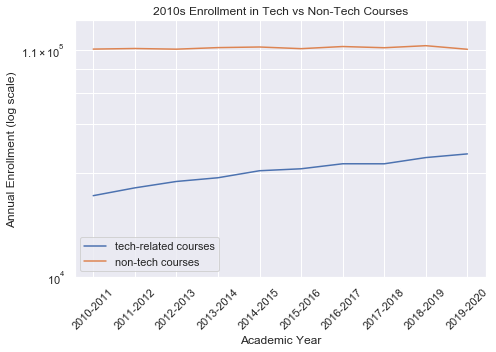

In [55]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_not_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] == 0) & (year_enrollment_df['subject'] != 'CS')]
df_not_tech = df_not_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.tight_layout()
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df_tech.index, df_tech['enrollment'], label='tech-related courses')

ax.plot(df_not_tech.index, df_not_tech['enrollment'], label='non-tech courses')

ax.set_ylabel('Annual Enrollment (log scale)')
ax.set_xlabel('Academic Year')
ax.set_title('2010s Enrollment in Tech vs Non-Tech Courses')
ax.legend()
ax.set_yscale('log')
ax.set_yticks([1e4, 3e4,5e4,7e4,9e4,11e4])
ax.set_ylim((10000, 150000))
ax.set_xticklabels(df_tech.index, rotation=45)
fig.savefig('tech_non-tech_enrollment_log.png', format='png')

<Figure size 432x288 with 0 Axes>

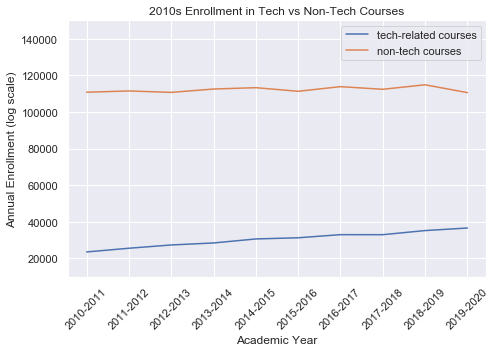

In [49]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_not_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] == 0) & (year_enrollment_df['subject'] != 'CS')]
df_not_tech = df_not_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.tight_layout()
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df_tech.index, df_tech['enrollment'], label='tech-related courses')

ax.plot(df_not_tech.index, df_not_tech['enrollment'], label='non-tech courses')

ax.set_ylabel('Annual Enrollment (log scale)')
ax.set_xlabel('Academic Year')
ax.set_title('2010s Enrollment in Tech vs Non-Tech Courses')
ax.legend()
ax.set_ylim((10000, 150000))
ax.set_xticklabels(df_tech.index, rotation=45)
fig.savefig('tech_non-tech_enrollment_nolog.png', format='png')

### Enrollment in tech + ethics classes

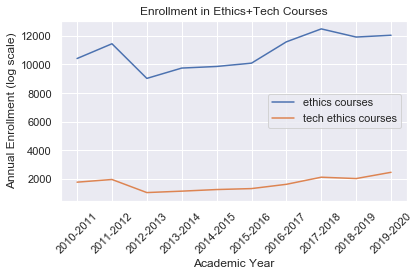

In [104]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_ethics = year_enrollment_df.loc[(year_enrollment_df['ethics_description'] > 0)]
df_ethics = df_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_tech_ethics = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['ethics_description'] > 0)]
df_tech_ethics = df_tech_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

fig, ax = plt.subplots(figsize=(6, 4))
#ax.plot(df_tech.index, df_tech['enrollment'], label='tech-related courses')
ax.plot(df_ethics.index, df_ethics['enrollment'], label='ethics courses')
ax.plot(df_tech_ethics.index, df_tech_ethics['enrollment'], label='tech ethics courses')

ax.set_ylabel('Annual Enrollment (log scale)')
ax.set_xlabel('Academic Year')
ax.set_title('Enrollment in Ethics+Tech Courses')
ax.legend(loc='center right')
ax.set_xticklabels(df_tech.index, rotation=45)

fig.savefig('tech_ethics_enrollment.png', format='png')

In [105]:
df_ethics

,enrollment,count
year,,
2010-2011,10412,429
2011-2012,11443,456
2012-2013,9023,499
2013-2014,9745,518
2014-2015,9857,602
2015-2016,10089,617
2016-2017,11579,659
2017-2018,12481,733
2018-2019,11912,724


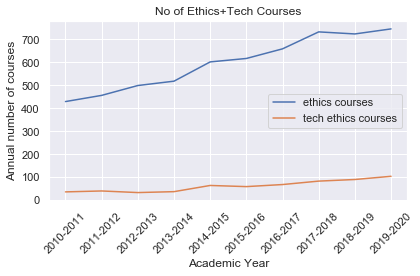

In [106]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_ethics = year_enrollment_df.loc[(year_enrollment_df['ethics_description'] > 0)]
df_ethics = df_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_tech_ethics = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['ethics_description'] > 0)]
df_tech_ethics = df_tech_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(df_ethics.index, df_ethics['count'], label='ethics courses')
ax.plot(df_tech_ethics.index, df_tech_ethics['count'], label='tech ethics courses')

ax.set_ylabel('Annual number of courses')
ax.set_xlabel('Academic Year')
ax.set_title('No of Ethics+Tech Courses')
ax.legend(loc='center right')
ax.set_xticklabels(df_ethics.index, rotation=45)

fig.savefig('tech_ethics_count.png', format='png')

### (CS Tech Ethics courses)

In [110]:
cs_tech_ethics = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')\
                                       &(year_enrollment_df['ethics_description'] > 0)]
cs_tech_ethics = cs_tech_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})
cs_tech_ethics

,enrollment,count
year,,
2010-2011,70,2
2014-2015,212,2
2015-2016,499,6
2016-2017,1105,7
2017-2018,1385,7
2018-2019,1170,9
2019-2020,1053,13


### Enrollment in CS 181 + 182

[]

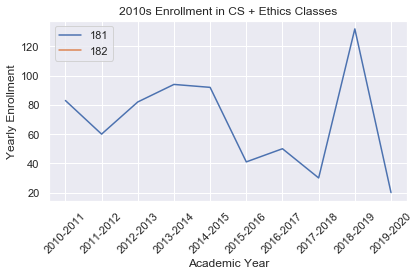

In [108]:
codes = ['181', '182']

for code in codes:
    code_df = year_enrollment_df.loc[(year_enrollment_df['code'] == code) & (year_enrollment_df['subject'] == 'CS')]
    plt.plot(code_df['year'], code_df['enrollment'], label=code)

plt.ylabel('Yearly Enrollment')
plt.xlabel('Academic Year')
plt.title('2010s Enrollment in CS + Ethics Classes')
plt.legend()
plt.xticks(rotation=45)
plt.plot()